<a name="Libraries"></a>
## 1. importing libraries


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt


from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

<a name="Data"></a>
## 2. Loading and previewing data

In [ ]:
# Function for features engineering
def create_df(data_path):

  # Reading file
  df = pd.read_csv(data_path)

  # Identifying columns with 50% null values
  result = df.loc[:, df.isnull().mean() > 0.5]
  mask_null = result.columns
  df.drop(columns =  mask_null, inplace=True)


  # Getting columns
  def get_cols_with_word(df, word):
    return [col for col in df.columns if word in col]
  object_cols = ["Place_ID", "Date", "Place_ID X Date"]
  target_col = get_cols_with_word(df, "target")
  features = df.columns.drop(object_cols + target_col)

  # Imputing nal values
  imputer = KNNImputer(n_neighbors=5, weights='distance')
  df_imputed = imputer.fit_transform(df[features])
  df.loc[:, features] =df_imputed

  # df.loc[:, features] = df[features].interpolate(method='linear')


  return df

In [ ]:
DATA_PATH = '/content/drive/MyDrive/'
# Load raw files
train_df = pd.read_csv(f"{DATA_PATH}Train.csv")
test_df = pd.read_csv(f"{DATA_PATH}Test.csv")
samplesubmission = pd.read_csv(f"{DATA_PATH}SampleSubmission.csv")
train = pd.read_csv(f"{DATA_PATH}Train.csv")

# Load modified files
train = create_df(f"{DATA_PATH}Train.csv")
test = create_df(f"{DATA_PATH}Test.csv")


print(train.shape, test.shape)

(30557, 75) (16136, 70)


In [ ]:
#sum of negative values
print((train[features] < 0).sum())

precipitable_water_entire_atmosphere                       0
relative_humidity_2m_above_ground                          0
specific_humidity_2m_above_ground                          0
temperature_2m_above_ground                             4106
u_component_of_wind_10m_above_ground                   13888
v_component_of_wind_10m_above_ground                   15201
L3_NO2_NO2_column_number_density                          28
L3_NO2_NO2_slant_column_number_density                     0
L3_NO2_absorbing_aerosol_index                         27477
L3_NO2_sensor_altitude                                     0
L3_NO2_stratospheric_NO2_column_number_density             0
L3_NO2_tropopause_pressure                                 0
L3_NO2_tropospheric_NO2_column_number_density            170
L3_O3_O3_column_number_density                             0
L3_O3_O3_effective_temperature                             0
L3_CO_CO_column_number_density                             0
L3_CO_H2O_column_number_

The negative values are in fields which can justifiably have negative values

<a name="Statistics"></a>
## 3. Statistical summaries

In [ ]:
# Choosing scaler
yeojohnson = True
standard_scaler = False

In [ ]:
if yeojohnson:
  # apply yeojohnson transform
  X_Scaler = PowerTransformer(method='yeo-johnson')
  y_Scaler = PowerTransformer(method='yeo-johnson')
elif standard_scaler:
  X_Scaler = StandardScaler()
  y_Scaler = StandardScaler()


train.loc[:, features] = X_Scaler.fit_transform(train[features])
train.loc[:, ['target']] = y_Scaler.fit_transform(train[['target']])

In [ ]:
# Train statistical summary
train["target"].describe()

count    3.055700e+04
mean    -1.590507e-16
std      1.000016e+00
min     -3.561124e+00
25%     -8.227990e-01
50%      4.620347e-02
75%      6.845684e-01
max      4.455177e+00
Name: target, dtype: float64

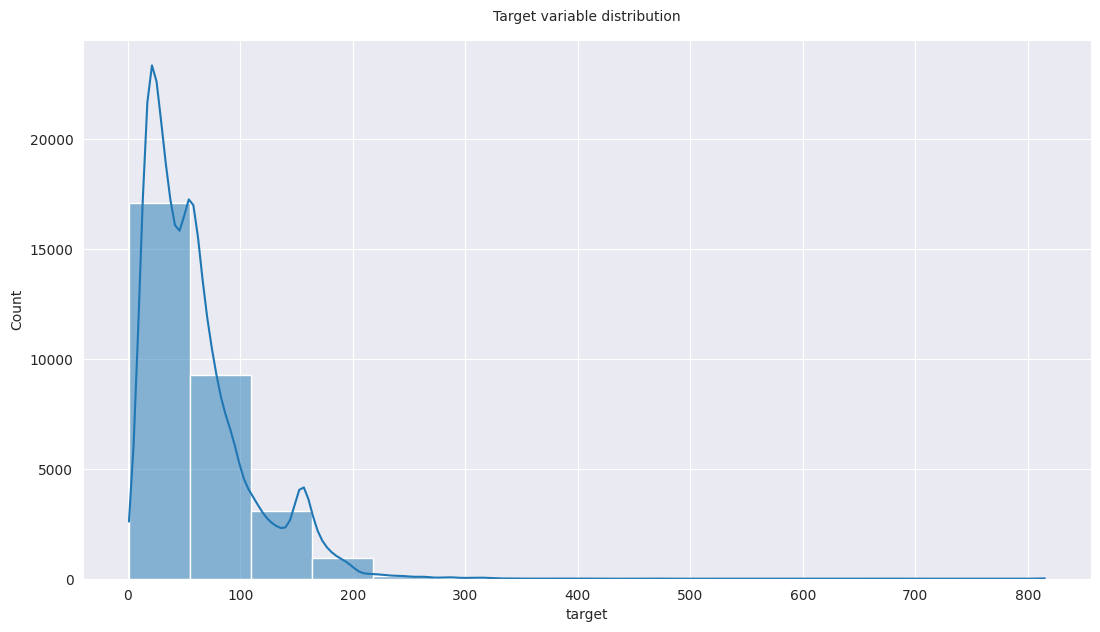

None

2.043157339845919

In [ ]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train_df.target, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 10)
display(plt.show(), train_df.target.skew())

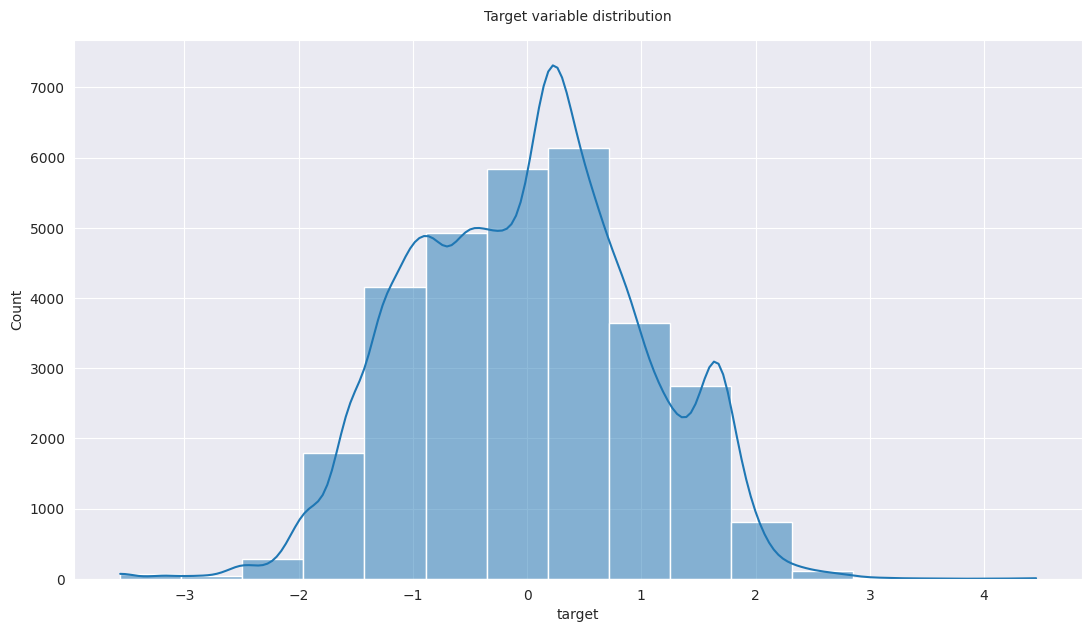

None

-0.008725973508909189

In [ ]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.target, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 10)
display(plt.show(), train.target.skew())

<a name="Missing"></a>
## 4. Missing values and duplicates

In [ ]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

In [ ]:
# Perform linear interpolation on the data frame
#df.interpolate(method='linear', inplace=True)

In [ ]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

<a name="Outliers"></a>
## 5. Outliers


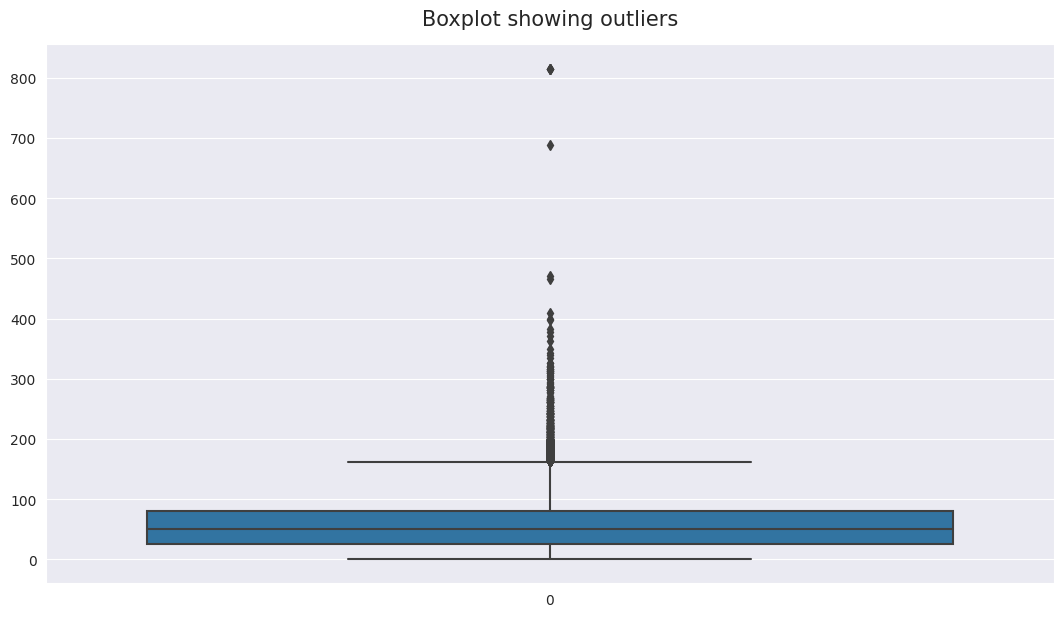

In [ ]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train_df.target)
plt.title('Boxplot showing outliers', y = 1.02, fontsize = 15)
plt.show()

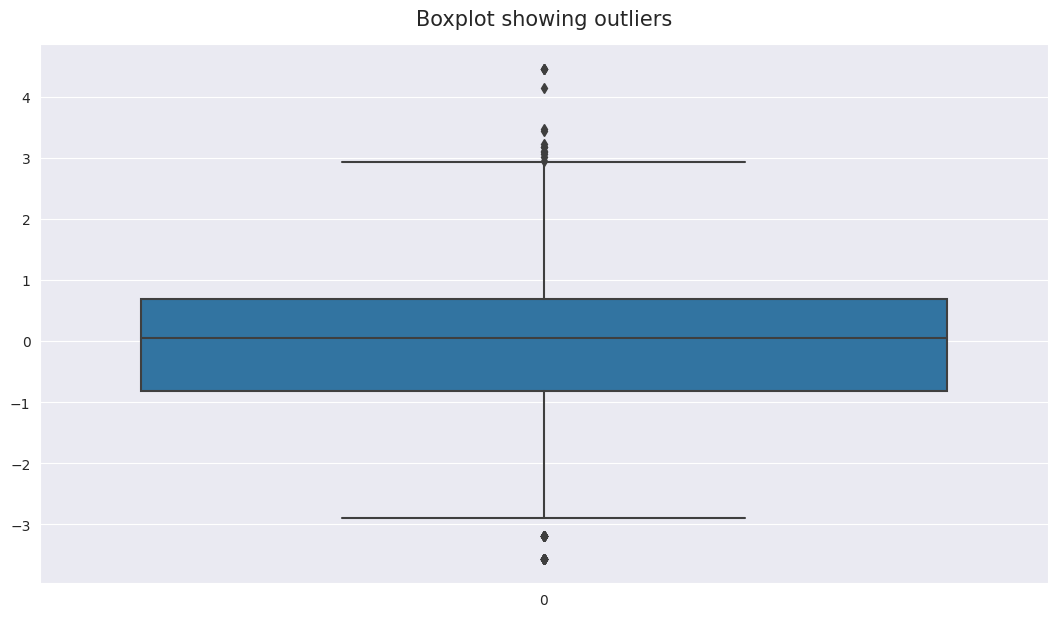

In [ ]:
# Plotting boxplot for the target
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.target)
plt.title('Boxplot showing outliers', y = 1.02, fontsize = 15)
plt.show()

<a name="Engineering"></a>
## 10. Feature engineering









<a name="Modelling"></a>
## 11.  Modelling

* **Splitting the data**
- Split basing on cities (20% -> 65 cites in the test data)


## Random Forest

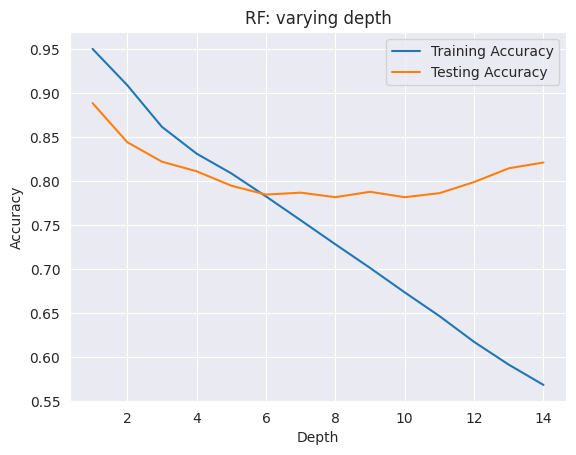

In [ ]:
# select unique items
cities = train['Place_ID'].unique()

# create a new DataFrame with the selected unique items
Test= train[train['Place_ID'].isin(cities[:65])]
Train = train[~train['Place_ID'].isin(cities[:65])]

target = 'target'
# Spliting data
X_Train = Train[features]
y_Train = Train[target]

X_Test = Test[features]
y_Test = Test[target]

# Create neighbors
depth = np.arange(1, 15)
train_accuracies = {}
test_accuracies = {}

for max_depth in depth:
  # Set up model
  clf = RandomForestRegressor(random_state =0, n_jobs=-1, n_estimators=2,
                           max_depth=max_depth)

  clf.fit(X_Train, y_Train)

  # Making predictions
  y_pred_train = clf.predict(X_Train)
  y_pred_test = clf.predict(X_Test)

  # Compute accuracy
  train_accuracies[max_depth] = mean_squared_error(y_Train, y_pred_train, squared=False)
  test_accuracies[max_depth] = mean_squared_error(y_Test, y_pred_test, squared=False)

plt.title("RF: varying depth")

# Plot training accuracies
plt.plot(depth, train_accuracies.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot( depth, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

# Display the plot
plt.show()

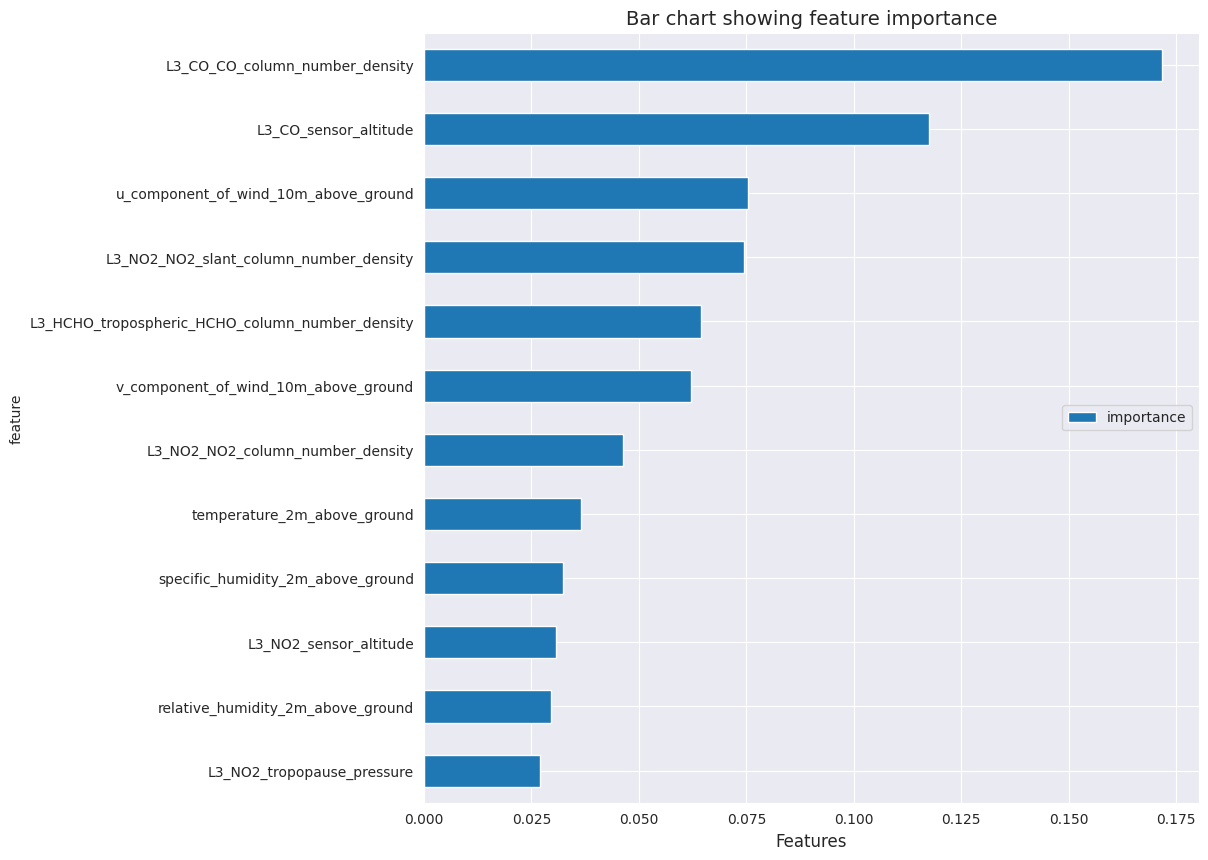

In [ ]:
# Feature importance
impo_df = pd.DataFrame({'feature': train[features].columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

Combinining some features which are monotonic wiht the target

In [ ]:
target_cols = ['target_min', 'target_max', 'target_variance','target_count']
data = train.drop(columns=target_cols ,axis=1)
corr_matrix = data.corr(numeric_only=True)
corr_matrix['target'].sort_values(ascending=False)

target                                             1.000000
L3_HCHO_tropospheric_HCHO_column_number_density    0.315045
L3_CO_CO_column_number_density                     0.309330
L3_NO2_tropospheric_NO2_column_number_density      0.299076
L3_NO2_NO2_column_number_density                   0.297170
                                                     ...   
L3_SO2_solar_azimuth_angle                        -0.197178
L3_O3_solar_azimuth_angle                         -0.216206
L3_CLOUD_solar_azimuth_angle                      -0.219260
L3_AER_AI_solar_azimuth_angle                     -0.220057
L3_AER_AI_sensor_altitude                         -0.357970
Name: target, Length: 68, dtype: float64

In [ ]:
param_grid = {'max_depth': [2, 6, 10, None]}
tree_model = GridSearchCV(DecisionTreeRegressor(random_state=0),
 cv = 5,
 scoring = 'neg_mean_squared_error',
 param_grid = param_grid)


tree_model.fit(X_Train[['L3_HCHO_tropospheric_HCHO_column_number_density',
'L3_CO_CO_column_number_density',
'L3_NO2_tropospheric_NO2_column_number_density',
'L3_NO2_NO2_column_number_density']], y_Train)

X_Train['new_feat'] = tree_model.predict(X_Train[['L3_HCHO_tropospheric_HCHO_column_number_density',
'L3_CO_CO_column_number_density',
'L3_NO2_tropospheric_NO2_column_number_density',
'L3_NO2_NO2_column_number_density']])

X_Test['new_feat'] = tree_model.predict(X_Test[['L3_HCHO_tropospheric_HCHO_column_number_density',
'L3_CO_CO_column_number_density',
'L3_NO2_tropospheric_NO2_column_number_density',
'L3_NO2_NO2_column_number_density']])

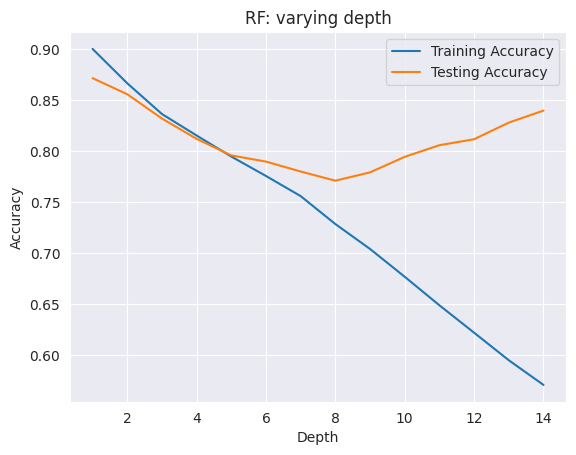

In [ ]:
# Create neighbors
depth = np.arange(1, 15)
train_accuracies = {}
test_accuracies = {}

for max_depth in depth:
  # Set up model
  rf = RandomForestRegressor(random_state =0, n_jobs=-1, n_estimators=2,
                           max_depth=max_depth)

  rf.fit(X_Train, y_Train)

  # Making predictions
  y_pred_train = rf.predict(X_Train)
  y_pred_test = rf.predict(X_Test)

  # Compute accuracy
  train_accuracies[max_depth] = mean_squared_error(y_Train, y_pred_train, squared=False)
  test_accuracies[max_depth] = mean_squared_error(y_Test, y_pred_test, squared=False)

plt.title("RF: varying depth")

# Plot training accuracies
plt.plot(depth, train_accuracies.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot( depth, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

# Display the plot
plt.show()

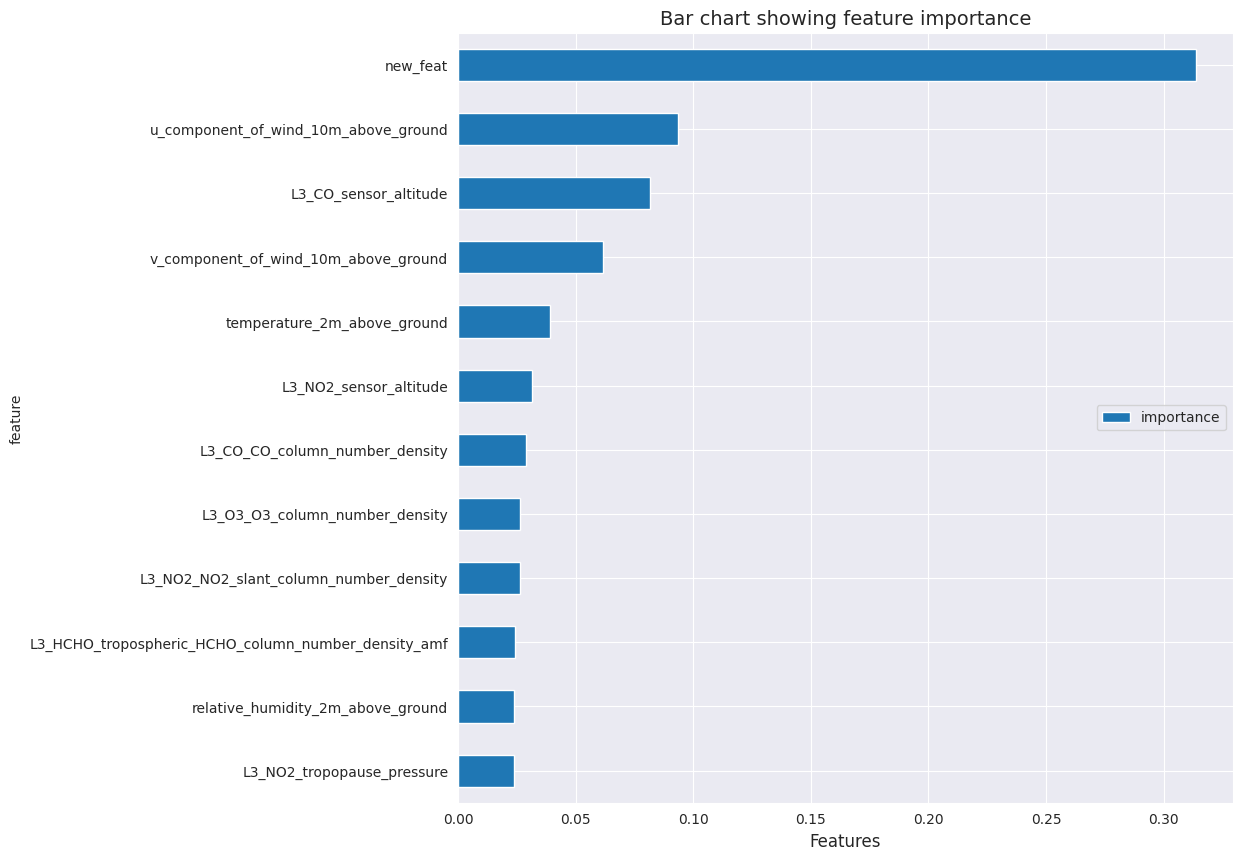

In [ ]:
# Feature importance
impo_df = pd.DataFrame({'feature': X_Train.columns, 'importance': rf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

In [ ]:
# Model Selection
RF = True
DT = False
RG = False
POLY  = False
deg = 2

In [70]:
# Instantiating the model

if RF:
  model = RandomForestRegressor(random_state = 0, n_estimators=2,
                           max_depth=6)
elif DT:
  model = DecisionTreeRegressor(max_depth=2, random_state=0)
elif RG:
  model = Ridge()
elif POLY:
    # Transform the train features to a higher degree polynomial
  poly_features = PolynomialFeatures(degree=deg)
  X_train = poly_features.fit_transform(X_Train)
  model = LinearRegression()

model.fit(X_Train, y_Train)
# Making predictions
y_pred_train = model.predict(X_Train)

# Measuring the accuracy of the model
print(f'Train RMSE Score: {mean_squared_error(y_Train, y_pred_train, squared=False).round(3)}') # 31.612502792990366

Train RMSE Score: 0.776


In [91]:
y_pred_train

array([-0.16516838, -0.25986256, -0.83505125, ...,  0.19726903,
        0.19726903,  0.10195048])

Results

RF :0.867
DT : 0.871
RG : 0.814
POLY : 0.806

<a name="Predictions"></a>
## 12. Making predictions of the test set and creating a submission file

In [72]:
samplesubmission.head(10)

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,0
1,0OS9LVX X 2020-01-03,0
2,0OS9LVX X 2020-01-04,0
3,0OS9LVX X 2020-01-05,0
4,0OS9LVX X 2020-01-06,0
5,0OS9LVX X 2020-01-07,0
6,0OS9LVX X 2020-01-08,0
7,0OS9LVX X 2020-01-09,0
8,0OS9LVX X 2020-01-10,0
9,0OS9LVX X 2020-01-11,0


In [86]:
feats = ['precipitable_water_entire_atmosphere',
 'relative_humidity_2m_above_ground',
 'specific_humidity_2m_above_ground',
 'temperature_2m_above_ground',
 'u_component_of_wind_10m_above_ground',
 'v_component_of_wind_10m_above_ground',
 'L3_NO2_NO2_column_number_density',
 'L3_NO2_NO2_slant_column_number_density',
 'L3_NO2_absorbing_aerosol_index',
 'L3_NO2_sensor_altitude',
 'L3_NO2_stratospheric_NO2_column_number_density',
 'L3_NO2_tropopause_pressure',
 'L3_NO2_tropospheric_NO2_column_number_density',
 'L3_O3_O3_column_number_density',
 'L3_O3_O3_effective_temperature',
 'L3_CO_CO_column_number_density',
 'L3_CO_H2O_column_number_density',
 'L3_CO_sensor_altitude',
 'L3_HCHO_HCHO_slant_column_number_density',
 'L3_HCHO_tropospheric_HCHO_column_number_density',
 'L3_HCHO_tropospheric_HCHO_column_number_density_amf',
 'L3_AER_AI_absorbing_aerosol_index',
 'L3_AER_AI_sensor_altitude',
 'L3_SO2_SO2_column_number_density',
 'L3_SO2_SO2_column_number_density_amf',
 'L3_SO2_SO2_slant_column_number_density',
 'L3_SO2_absorbing_aerosol_index',
 'new_feat'                                             ]

In [78]:

test['new_feat'] = tree_model.predict(test[['L3_HCHO_tropospheric_HCHO_column_number_density',
'L3_CO_CO_column_number_density',
'L3_NO2_tropospheric_NO2_column_number_density',
'L3_NO2_NO2_column_number_density']])

In [87]:
# Make prediction on the test set
test_df = test.drop([ 'Place_ID X Date', 'Date', 'Place_ID'], axis = 1)

# Transform the data

test_af = X_Scaler.fit_transform(test_df)


predictions = model.predict(test_df[feats])

In [88]:

# # Create a submission file
sub_file = pd.DataFrame({"Place_ID": samplesubmission['Place_ID X Date'], 'target': predictions})
sub_file.loc[:, ['target']] = y_Scaler.inverse_transform(sub_file[['target']])
# print(f'Test RMSE Score: {mean_squared_error(y_pred_baseline, predictions, squared=False).round(3)}')

Model Perfomance before
* RF = Baseline
* DT = 23.782
* Ridge = 22.403
* Poly_2 = 19.53

In [92]:
sub_file.tail(10)

,Place_ID,target
16126,ZZDJZMS X 2020-03-26,27.371043
16127,ZZDJZMS X 2020-03-27,31.111432
16128,ZZDJZMS X 2020-03-28,31.111432
16129,ZZDJZMS X 2020-03-29,31.111432
16130,ZZDJZMS X 2020-03-30,31.111432
16131,ZZDJZMS X 2020-03-31,31.111432
16132,ZZDJZMS X 2020-04-01,31.111432
16133,ZZDJZMS X 2020-04-02,31.111432
16134,ZZDJZMS X 2020-04-03,31.217555
16135,ZZDJZMS X 2020-04-04,31.111432


In [93]:
# Create file
sub_file.to_csv(f'{DATA_PATH}sub.csv', index = False) # Download subfile and submit to zindi for scoring